# Example: Analysis of Covered Call Positions on AMD
A covered call is a two-leg strategy in which equity, e.g., stock or an ETF, is purchased, and then call contracts are sold on a share-for-share basis against those shares. Profit and loss of a covered call position:

* The maximum profit of a covered call is achieved if the stock price is at or above the call's strike price at expiration.
* Losses occur in covered calls if the stock price declines below the breakeven point. In addition, there is also an _opportunity risk_ if the stock price rises above the effective selling price of the covered call.

### Learning objectives and tasks
The objective of this example is to familiarize students with the analysis of covered call positions, in this case on [Advanced Micro Devices, Inc.](https://www.amd.com/en.html), with the ticker symbol `AMD.`

## Setup
Set up the computational environment using the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

## Prerequisites
Before doing anything else, we load the `AMD` options chain data before the market opens on `11-11-2024` and save this data in the `dataset::DataFrame` variable. This data was downloaded [from Barchart.com](https://www.barchart.com/).

In [5]:
dataset = CSV.read(joinpath(_PATH_TO_DATA, "amd-options-exp-2024-12-20-monthly-near-the-money-stacked-11-11-2024.csv"), DataFrame)

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,OI,Delta,IV,Type
,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,String7
1,100.0,0.3241,48.6,48.8,49.0,50.62,0,2002,0.97487,0.64,Call
2,105.0,0.2903,43.7,43.9,44.1,45.15,0,160,0.96777,0.5938,Call
3,110.0,0.2565,38.75,38.95,39.15,40.1,0,4906,0.96248,0.5322,Call
4,115.0,0.2227,33.9,34.1,34.3,35.85,3,4162,0.94972,0.4921,Call
5,120.0,0.1889,29.25,29.38,29.5,29.28,30,881,0.93279,0.4506,Call
6,125.0,0.1551,24.6,24.73,24.85,25.0,30,627,0.8974,0.4344,Call
7,130.0,0.1213,20.2,20.3,20.4,20.3,585,3890,0.85167,0.4121,Call
8,135.0,0.0875,16.15,16.23,16.3,16.05,57,1357,0.78606,0.3981,Call
9,140.0,0.0537,12.55,12.63,12.7,12.5,265,3064,0.70103,0.3908,Call


 Let's set the parameters for `AMD` so we can use these data below:

In [7]:
DTE = 41.0; # days to expiration
Sₒ = 147.95; # AMD underlying share price USD/share, close 11/08/2024
Δt = (1/365); # Time step 1-trading day
risk_free_rate = 0.0431; # yield 10-year treasury note on 13-Jun-2024
h = 328; # 8-points per day
w = 0.3; # width parameter

## Task 1: Select a random call option from the dataset
In this task, we'll select call option contracts such that $S_{\circ}<K\leq\left(1+w\right)\cdot{S}_{\circ}$ where $w>0$, and we purchase the counter asset, in this case shares, from the market at $S_{\circ}$. Let's begin by filtering the contracts in the `dataset::DataFrame` to include only `call` contracts that obey the strike price constraint.

Save the filtered selection of `call` contracts in the `call_contracts::DataFrame` variable:

In [9]:
call_contracts = filter(:Type=>x->x == "Call", dataset) |> y -> filter(:Strike=> x-> (x > Sₒ && x ≤ (1+w)*Sₒ), y)

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,OI,Delta,IV,Type
,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,String7
1,150.0,-0.0139,7.0,7.05,7.1,7.05,2689,11008,0.49959,0.3861,Call
2,155.0,-0.0477,5.0,5.03,5.05,5.02,2185,9746,0.39862,0.3836,Call
3,160.0,-0.0814,3.5,3.53,3.55,3.51,5149,11132,0.3075,0.3842,Call
4,165.0,-0.1152,2.41,2.44,2.47,2.44,2041,8257,0.23165,0.388,Call
5,170.0,-0.149,1.67,1.69,1.71,1.68,4058,9911,0.17101,0.3926,Call
6,175.0,-0.1828,1.18,1.19,1.21,1.2,1494,9184,0.12756,0.4026,Call
7,180.0,-0.2166,0.86,0.87,0.87,0.87,1813,12422,0.09557,0.4136,Call
8,185.0,-0.2504,0.63,0.64,0.65,0.65,928,5389,0.07285,0.4266,Call
9,190.0,-0.2842,0.49,0.5,0.51,0.49,302,8789,0.05584,0.439,Call


Select a random contract from the `call_contracts::DataFrames` collection; this will be our second leg of the strangle. Save the data for this contract in the `call_leg_data` variable, which is type [DataFrameRow](https://dataframes.juliadata.org/stable/lib/types/#DataFrames.DataFrameRow):

In [11]:
call_leg_data = nrow(call_contracts) |> i-> call_contracts[rand(1:i),:] # fancy!

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,OI,Delta,IV,Type
,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,String7
4,165.0,-0.1152,2.41,2.44,2.47,2.44,2041,8257,0.23165,0.388,Call


Next, build a [`MyAmericanCallContractModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanCallContractModel) using the `call` contract data and store this contract model in the `call_contract_model::MyAmericanCallContractModel` variable. 
* To access data from the `DataFrameRow,` pass in the column name. For example, to get the strike price, you would say: `call_leg_data[:Strike].` For the premium value, use the midpoint value.

In [13]:
call_contract_model = build(MyAmericanCallContractModel, (
    K = call_leg_data[:Strike], # set the strike price from the random call contract
    premium = call_leg_data[:Mid], # set the premium value from the random call contract
    sense = -1, # we are short, i.e., we *sold* this contract so sense = -1 
    copy = 1));

Finally, let's build a model of the equity counter asset, i.e., the shares for our covered call. We sold a single call contract; we need to own `100` shares of `AMD.`

In [15]:
my_equity_model = let

    Sₚ = 1.0*Sₒ; # we purchased at the market    
    my_equity_model = MyEquityModel(); # build an empty equity model
    my_equity_model.ticker = "AMD";
    my_equity_model.purchase_price = Sₚ;
    my_equity_model.current_price = Sₒ;
    my_equity_model.direction = 1;
    my_equity_model.number_of_shares = 100;

    # return
    my_equity_model;
end

MyEquityModel("AMD", 147.95, 147.95, 1, 100)

## Task 2: Analysis of the Profit and Loss of the Covered Call at Expiration
In this task, let's compute the breakeven point on this position and the profit and loss diagram for the covered call position at expiration. 

### General case
Let's start with the break-even analysis.
The overall payoff of a general composite contract set $\mathcal{C}$ with `d`-legs is denoted as $\hat{V}(S(T),K_{1},\dots,K_{d})$ and given by:
$$
\begin{equation*}
\hat{V}(S(T),K_{1},\dots,K_{d}) = \sum_{i\in\mathcal{C}}\theta_{i}n_{i}V_{i}(S(T),K_{i})
\end{equation*}
$$
where $K_{i}$ denotes the strike price of contract $i\in\mathcal{C}$. The overall profit of the composite contract $\hat{P}$ is given by:
$$
\begin{equation*}
\hat{P}(S(T),K_{1},\dots,K_{d}) = \sum_{i\in\mathcal{C}}\theta_{i}n_{i}P_{i}(S(T),K_{i})
\end{equation*}
$$
where $\theta_{i}$ denotes the direction of contract $i$: if contract $i$ is short (sold), then $\theta_{i}=-1$, otherwise $\theta_{i}=1$, $n_{i}$ denotes the copy number of contract $i$, ${V}_{i}(S(T),K_{i})$ denotes the payoff of contract $i$, and $P_{i}(S(T),K_{i})$ denotes the profit of contract $i$. Finally, the profit for the contract of type $\star$ is given by:
$$
\begin{equation*}
P_{\star}(K,S(T)) = {V}_{\star}(K,S(T)) -  \mathcal{P}_{\star}(K,S(0))
\end{equation*}
$$
where $\mathcal{P}_{\star}(K,S(0))$ denotes the premium of contract $\star$, and ${V}_{\star}(K,S(T))$ denotes the payoff of contract $\star$ at expiration.

### Covered Call
The covered call consists of long shares and a short-call contract. The profit expression (per share for a single covered call instance) is given by:
$$
\begin{equation*}
\hat{P}(S(T),K) = -1\cdot\left({V}_{c}(K,S(T)) -  \mathcal{P}_{c}(K,S(0))\right) + \left(S_{T} - S_{\circ}\right)
\end{equation*}
$$
where the second term is the profit per share on the long equity position, assuming we purchased the shares at $S_{\circ}$. The profit expression is simplified to:
$$
\hat{P}(S(T),K) = \mathcal{P}_{c} + \Delta{S} - (S_{T} - K)^{+}
$$
where $(S_{T} - K)^{+} \equiv \max(S_{T} - K,0)$ and $\Delta{S} = (S_{T} - S_{\circ})$.

Let's compute the deal flow for different close prices at expiration scenarios.
* __Scenario 1 Maximum Profit__: When the underlying share price closes _above_ the short strike $S_{T}\geq{K}+\epsilon$, where $\epsilon$ is at least $\epsilon\geq{0.01}$ USD/share, we recieve the maximum profit of $\mathcal{P}_{c} + \left(K-S_{\circ}\right)$ on the trade.
* __Scenario 2 Maximum Loss__: When the underlying share price goes to zero at expiration $S_{T}\rightarrow{0}$, the maximum loss is given by $\mathcal{P}_{c} - S_{\circ}$.
* __Scenario 3 Breakeven__: We break even on the trade, i.e., $\hat{P} = 0$, when $S_{T} = B$, where $B = S_{\circ} - \mathcal{P}_{c}$.

In [17]:
max_profit, max_loss, B = let

    # setup
    K = call_contract_model.K; # short strike
    𝒫 = call_contract_model.premium;
    
    # scenarios -
    max_profit = 𝒫 + (K - Sₒ); # max profit case
    max_loss = 𝒫 - Sₒ; # max loss, both contracts expire worthless 
    B = Sₒ - 𝒫;

    # return
    max_profit, max_loss, B
end;

In [18]:
println("Max profit = $(max_profit), max loss = $(max_loss) and breakeven = $(B) USD/share") 

Max profit = 19.490000000000013, max loss = -145.51 and breakeven = 145.51 USD/share


### Visualize
Now that we have analytically computed the maximum profit, maximum loss, and breakeven values, let's visualize the profit diagram at expiration for the covered call. To do this, build an array of share prices at expiration and save this in the `share_price_array::Array{Float64,1}` variable. 
* We'll look at a range around the share acquisition price $w\cdot{S_{\circ}}$ and $\left(2-w\right)\cdot{S}_{\circ}$, where $w$ is a width parameter $0<w<1$ that we specify.

In [20]:
share_price_array = let

    w = 0.80; # width of range to explore. Adjust me to see what happens
    number_of_steps = 1001; # leave me alone!

    # build a range, then pass that to collect (which gives an array)
    share_price_array = range((w)*Sₒ,stop = (2-w)*Sₒ, length = number_of_steps) |> collect;

    # return the data
    share_price_array;
end;

Finally, compute the profit for the short strangle. We compute the profit by [calling the `profit(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.profit) and save the profit values in the `profit_array` variable. The [`profit(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.profit) takes two arguments, the contract models as an array and the share price array.

* The `profit_array` will be a `1001`$\times$ `4` array, in which each row is a possible value for the share price at expiration $S_{T}$. Column `1` holds the possible $S_{T}$ values, column `2` holds the profit for the shares, column `3` holds the profit for the short `call,` and column `4` holds the overall profit for the composite trade.

In [22]:
profit_array = profit([call_contract_model], my_equity_model, share_price_array)

1001×4 Matrix{Float64}:
 118.36     2.44     -29.59    -27.15
 118.419    2.44     -29.5308  -27.0908
 118.478    2.44     -29.4716  -27.0316
 118.538    2.44     -29.4125  -26.9725
 118.597    2.44     -29.3533  -26.9133
 118.656    2.44     -29.2941  -26.8541
 118.715    2.44     -29.2349  -26.7949
 118.774    2.44     -29.1757  -26.7357
 118.833    2.44     -29.1166  -26.6766
 118.893    2.44     -29.0574  -26.6174
 118.952    2.44     -28.9982  -26.5582
 119.011    2.44     -28.939   -26.499
 119.07     2.44     -28.8798  -26.4398
   ⋮                           
 176.889   -9.44902   28.939    19.49
 176.948   -9.5082    28.9982   19.49
 177.007   -9.56738   29.0574   19.49
 177.067   -9.62656   29.1166   19.49
 177.126   -9.68574   29.1757   19.49
 177.185   -9.74492   29.2349   19.49
 177.244   -9.8041    29.2941   19.49
 177.303   -9.86328   29.3533   19.49
 177.362   -9.92246   29.4125   19.49
 177.422   -9.98164   29.4716   19.49
 177.481  -10.0408    29.5308   19.49
 177.54  

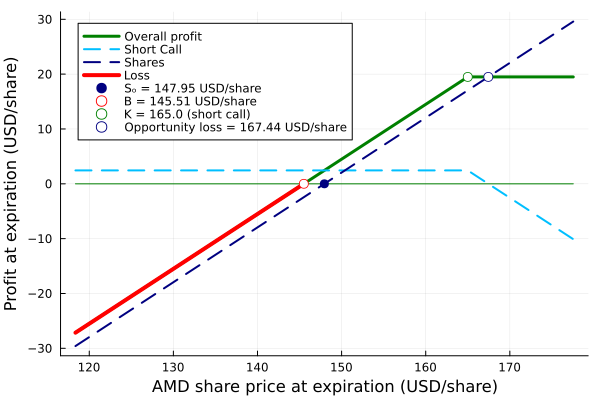

In [23]:
let
    # initialize 
    N = length(profit_array[:,1]); # how many steps do we have?
    BEL = zeros(N);
    K = call_contract_model.K;
    Sₚ = my_equity_model.purchase_price

    # SPL_vertical = range(-100,stop=100,length=N) |> collect;
    SPL_horizontal = Sₒ*ones(N);
    STRIKE_horizontal = K;
    max_profit = (call_contract_model.premium)+(K-Sₚ);
    max_profit_intersection = K + call_contract_model.premium;
    B = Sₚ - call_contract_model.premium;

    # setup the coloring -
    profit_idx = findall(>(0), profit_array[:,end])
    alternative_loss_index = findall(x->x ≥ max_profit_intersection, profit_array[:,end]);
    loss_array = profit_array[:,:]; loss_array[profit_idx,:] .= NaN
    
    plot(profit_array[:,1],profit_array[:,end], lw=3, c=:green, label="Overall profit")
    plot!(profit_array[:,1], BEL, c=:green, lw=1, label="")
    plot!(profit_array[:,1],profit_array[:,2], lw=2, c=:deepskyblue1, label="Short Call", ls=:dash)
    plot!(profit_array[:,1],profit_array[:,3], lw=2, c=:navy, label="Shares", ls=:dash)
    plot!(loss_array[:,1], loss_array[:,4], lw=4, label="Loss", c=:red)
    scatter!([Sₚ], [0], ms=5, c=:navy, msc=:navy, ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    scatter!([B], [0], ms=5, c=:white, msc=:red, ls=:dash, label="B = $(B) USD/share")
    scatter!([K],[max_profit], ms=5, label = "K = $(K) (short call)", msc=:green, c=:white)
    scatter!([max_profit_intersection],[max_profit], ms=5, label = "Opportunity loss = $(max_profit_intersection) USD/share", msc=:navy, c=:white)
    
    xlabel!("AMD share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit at expiration (USD/share)", fontsize=18)
end

## Task 3: Probability of Outcomes
In this task, let's compute the probability of observing exit scenarios for our covered call position on `AMD.` We'll consider three scenarios
Fill me in.

* __Scenario 1: Downside loss__. In this scenario, the share price at expiration $S_{T}$ is at least $\epsilon$ _below_ the downside breakeven point $B$, assuming $\epsilon \geq $ `0.01` USD/share. The probability of this scenario occurring is given by $P(S_{T}\leq{B} - \epsilon) = F_{S}\left(B^{-} - \epsilon\right)$.
* __Scenario 2: Maximum profit__. In this scenario, the share price at expiration $S_{T}$ exceeds the strike price $K$. The probability of this scenario occurring is given by $P(S_{T} > K) = 1 - F_{S}\left(K\right)$.
* __Scenario 3: Upside opportunity loss__. In this scenario, the share price at expiration $S_{T}$ is at least $\epsilon$ _above_ the alternative oppurtunity point $O^{+}$, assuming $\epsilon \geq $ `0.01` USD/share. The probability of this scenario occurring is given by $P(S_{T}>O^{+} + \epsilon) = 1 - F_{S}\left(O^{+} + \epsilon\right)$.

### Geometric Brownian Motion (GBM)
Build an instance of the [MyGeometricBrownianMotionEquityModel type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) which holds values for the drift `μ` and volatility `σ` parameters using a [custom build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}). 
* We set the drift parameter to the risk-free rate $\mu = \bar{r}$ (because options use a risk-neutral probability measure), and the volatility is set to the implied volatility estimate $\sigma = \text{IV}$ from the options chain data.

In [26]:
model, σ̄ = let

    # Step 1: get the implied volatility 
    σ̄ = call_leg_data[:IV];

    # Step 2: build the GBM model
    model = build(MyGeometricBrownianMotionEquityModel, (
        μ = risk_free_rate,
        σ = σ̄
    ));

    model, σ̄
end;

Now that we have a populated [MyGeometricBrownianMotionEquityModel instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) holding the `MU` data, let's generate `number_of_samples` possible future share price values using the [sample(...) function exported by the VLQuantitativeFinancePackage.jl package](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}).
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) takes a `model::MyGeometricBrownianMotionEquityModel` instance as the first argument, along with the time values that we wish to sample: `T₁::Float64` is the start time, `T₂::Float64` is the stop-time (in units of `years`), `Δt::Float64` is the time step (in units of `years`), and `Sₒ::Float64` denotes the initial share price (in units of `USD/share`). Finally, we pass in the number of samples we want to generate in the `number_of_paths` argument.
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) generates `number_of_paths` sample paths from $T_{1}\rightarrow{T}_{2}$ in steps of $\Delta{t}$. However, we only want the share prices corresponding to the duration of the contract, i.e., $T_{2} = \text{DTE}\cdot\Delta{t}$. Thus, we pass the full `samples` array [using the Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) to a slicing operation where we select columns `2:end` of the last row (col 1 holds the time). We store the `number_of_paths` samples of the share price at $T_{2}$ in the `endpoint::Array{Float64,1}` variable.

In [28]:
endpoint = let
    number_of_samples = 25000;
    endpoint = VLQuantitativeFinancePackage.sample(model, (
        T₁ = 0.0,
        T₂ = (DTE)*(Δt),
        Δt = Δt,
        Sₒ = Sₒ
    ), number_of_paths = number_of_samples) |> samples -> samples[end,2:end]; # get last row from col 2 -> number_of_paths

    endpoint;
end;

We've previously shown that sampling a GBM model emits a LogNormal share price distribution. Fit a [LogNormal distribution exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.LogNormal) using the [fit_mle(...) function exported by Distributions.jl](https://juliastats.org/Distributions.jl/stable/fit/#Distributions.fit_mle-Tuple{Any,%20Any}), and save this in the `d_gbm` variable

In [30]:
d_gbm = fit_mle(LogNormal, endpoint);

### Cumulative distribution
Next, estimate [the cumulative distribution function (CDF)](https://en.wikipedia.org/wiki/Cumulative_distribution_function) for the geometric Brownian motion and implied volatility share price distributions. 
We can query the cumulative distribution function $F_{S}(\star)$ using for the projected geometric Brownian motion distribution `d_gbm` using [the `cdf(...)` function exported by the Distributions.jl package](https://github.com/JuliaStats/Distributions.jl?tab=readme-ov-file).

#### Refresher
Before starting the calculations, let's quickly refresh our knowledge of what the cumulative probability distribution function tells us. The cumulative distribution function of a real-valued random variable $X$ (this is share price at expiration in our case) is given by:
$$
P(X\leq{x}) = F_{X}(x)
$$
that is, the probability that we see a value for the random variable $X$ less than or equal to the specified value $x$ is the cumulative distribution function evaluated at $x$. Alternatively, $P(X>x)$ is given by:
$$
P(X>{x}) = 1 - F_{X}(x)
$$
Lastly, the probability that $X$ (share price at expiration) lies in the interval $(a,b]$, where $a < b$ is given by:
$$
P(a < X \leq b) = F_{X}(b) - F_{X}(a)
$$
In [Julia we can use the `cdf(...)` function exported from the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.cdf-Tuple{UnivariateDistribution,%20Real}) to compute $F_{S}\left(x\right)$.

#### Visualize
`Unhide` the code block below to see how we plotted the cumulative distribution function (CDF) for `AMD` share price at contract expiration using the risk-neutral geometric Brownian motion `d_gbm` model:

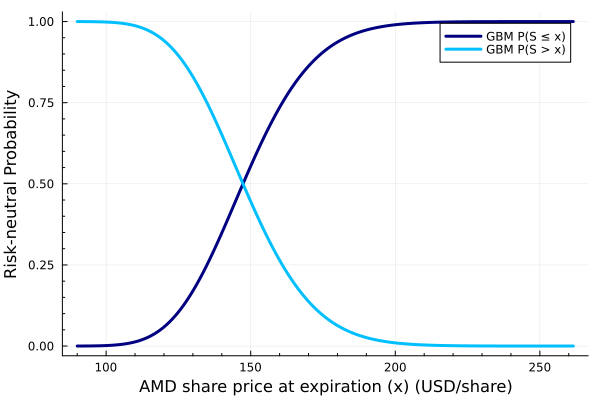

In [33]:
let
    number_of_samples = length(endpoint);
    X = Array{Float64,2}(undef, number_of_samples, 2);
    S = Array{Float64,1}();
    for i ∈ eachindex(endpoint)
        push!(S,endpoint[i]);
    end
    S = sort(S);
    
    for i ∈ eachindex(S)
    
        X[i,1] = S[i];
        X[i,2] = cdf(d_gbm, S[i]);
    end

    plot(X[:,1], X[:,2], lw=3, c=:navy, label="GBM P(S ≤ x)", xminorticks=5, yminorticks=5)
    plot!(X[:,1], 1 .- X[:,2], lw=3, c=:deepskyblue1, label="GBM P(S > x)")

    xlabel!("AMD share price at expiration (x) (USD/share)", fontsize=18);
    ylabel!("Risk-neutral Probability", fontsize=18);
end

__Scenario 1: Downside loss__. In this scenario, the share price at expiration $S_{T}$ is at least $\epsilon$ _below_ the downside breakeven point $B$, assuming $\epsilon \geq $ `0.01` USD/share. The probability of this scenario occurring is given by $P(S_{T}\leq{B} - \epsilon) = F_{S}\left(B^{-} - \epsilon\right)$.

In [35]:
p_downside_loss_gbm = let

    # initialize 
    ϵ = 0.01; # 1/100 USD
    p_downside_loss_gbm = nothing;

    # compute P(S < B_low -  ϵ) for the GBM model
    p_downside_loss_gbm = cdf(d_gbm,B-ϵ);

    # return data -
    p_downside_loss_gbm
end;

In [36]:
println("Scenario 1: Probability downside GBM = $(p_downside_loss_gbm)")

Scenario 1: Probability downside GBM = 0.4620087148457174


__Scenario 2: Maximum profit__. In this scenario, the share price at expiration $S_{T}$ exceeds the strike price $K$. The probability of this scenario occurring is given by $P(S_{T} > K) = 1 - F_{S}\left(K\right)$.

In [38]:
p_max_profit_gbm = let

    # initialize 
    ϵ = 0.01; # 1/100 USD
    p_max_profit_gbm = nothing;
    K = call_contract_model.K

    # compute the probability P(S > K) for the GBM
    p_max_profit_gbm = 1 - cdf(d_gbm,K)

    # return data -
    p_max_profit_gbm
end;

In [39]:
println("Scenario 2: Probability max profit GBM = $(p_max_profit_gbm)")

Scenario 2: Probability max profit GBM = 0.19372874737930412


__Scenario 3: Upside opportunity loss__. In this scenario, the share price at expiration $S_{T}$ is at least $\epsilon$ _above_ the alternative oppurtunity point $O^{+}$, assuming $\epsilon \geq $ `0.01` USD/share. The probability of this scenario occurring is given by $P(S_{T}>O^{+} + \epsilon) = 1 - F_{S}\left(O^{+} + \epsilon\right)$.

In [41]:
p_upside_opp_loss = let

    # initialize 
    ϵ = 0.01; # 1/100 USD
    p_upside_opp_loss = nothing;
    K = call_contract_model.K
    OP = K + call_contract_model.premium;

    # compute the probability P(S > O + e) for the GBM
    p_upside_opp_loss = 1 - cdf(d_gbm, OP + ϵ)

    # return data -
    p_upside_opp_loss
end;

In [42]:
println("Scenario 3: Probability of upside opportunity loss GBM = $(p_upside_opp_loss)")

Scenario 3: Probability of upside opportunity loss GBM = 0.16435948234689046


## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.